In [14]:
!pip install pandas pandasql matplotlib seaborn scikit-learn xgboost plotly prophet openpyxl


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")


In [16]:
# Load dataset
df = pd.read_csv('/content/data.csv', encoding='unicode_escape')  # Make sure this is uploaded in Colab

# Keep only relevant columns
df = df[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

# Clean
df.dropna(inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M').astype(str)
df['Month'] = df['InvoiceDate'].dt.month
df['Weekday'] = df['InvoiceDate'].dt.weekday
df['Hour'] = df['InvoiceDate'].dt.hour

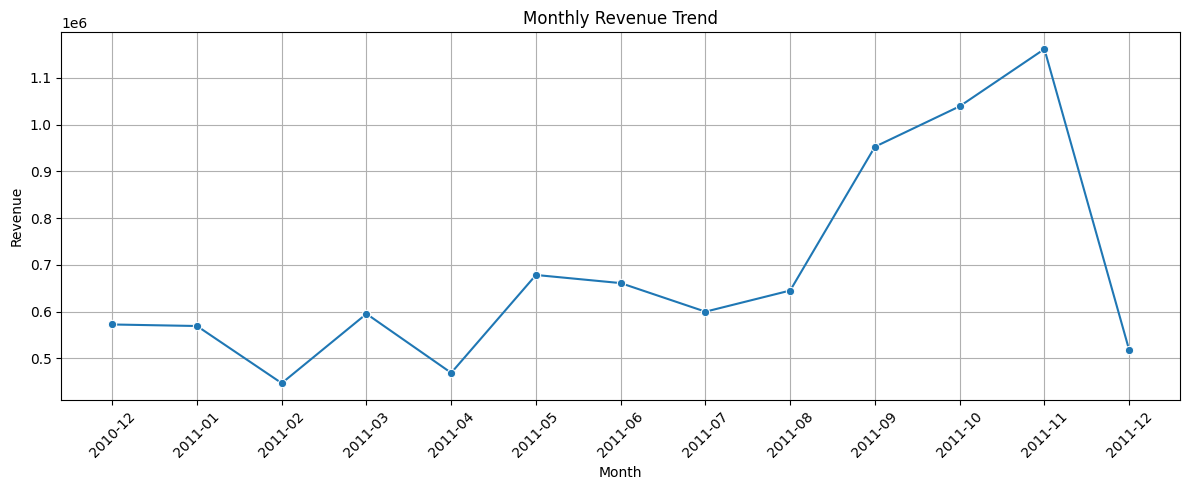

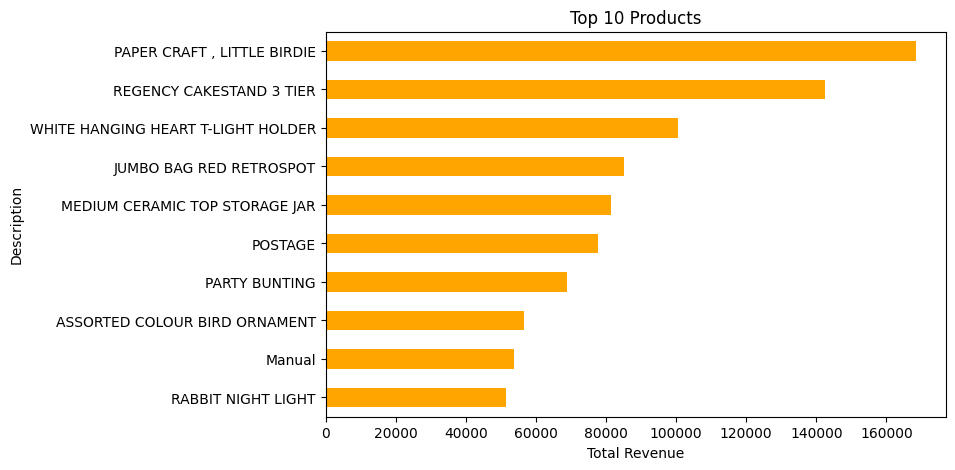

In [17]:
# Revenue over time
monthly = df.groupby('YearMonth')['TotalPrice'].sum().reset_index()
monthly.columns = ['Month', 'Revenue']

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly, x='Month', y='Revenue', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.grid(True)
plt.tight_layout()
plt.show()

# Top products
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(8,5), title="Top 10 Products", color='orange')
plt.xlabel("Total Revenue")
plt.gca().invert_yaxis()
plt.show()


In [18]:
pysqldf = lambda q: sqldf(q, globals())

query = """
SELECT Country, SUM(TotalPrice) as Revenue
FROM df
GROUP BY Country
ORDER BY Revenue DESC
LIMIT 10;
"""
print(pysqldf(query))


          Country       Revenue
0  United Kingdom  7.308392e+06
1     Netherlands  2.854463e+05
2            EIRE  2.655459e+05
3         Germany  2.288671e+05
4          France  2.090240e+05
5       Australia  1.385213e+05
6           Spain  6.157711e+04
7     Switzerland  5.644395e+04
8         Belgium  4.119634e+04
9          Sweden  3.837833e+04


In [19]:
df['Day'] = df['InvoiceDate'].dt.day
features = df[['Quantity', 'UnitPrice', 'Day', 'Month', 'Weekday', 'Hour']]
target = df['TotalPrice']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, pred_rf))
print("MAE:", mean_absolute_error(y_test, pred_rf))


Random Forest R²: 0.9799004113633917
MAE: 0.2290263920480532


In [21]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)

print("XGBoost R²:", r2_score(y_test, pred_xgb))


XGBoost R²: -4.133326342445009


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyp7x1rbv/0g31ozl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyp7x1rbv/cskscx3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82967', 'data', 'file=/tmp/tmpyp7x1rbv/0g31ozl0.json', 'init=/tmp/tmpyp7x1rbv/cskscx3e.json', 'output', 'file=/tmp/tmpyp7x1rbv/prophet_modelcnof1wps/prophet_model-20250704070518.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:05:18 - cmdstanpy - INFO - Chain [1] start processing
IN

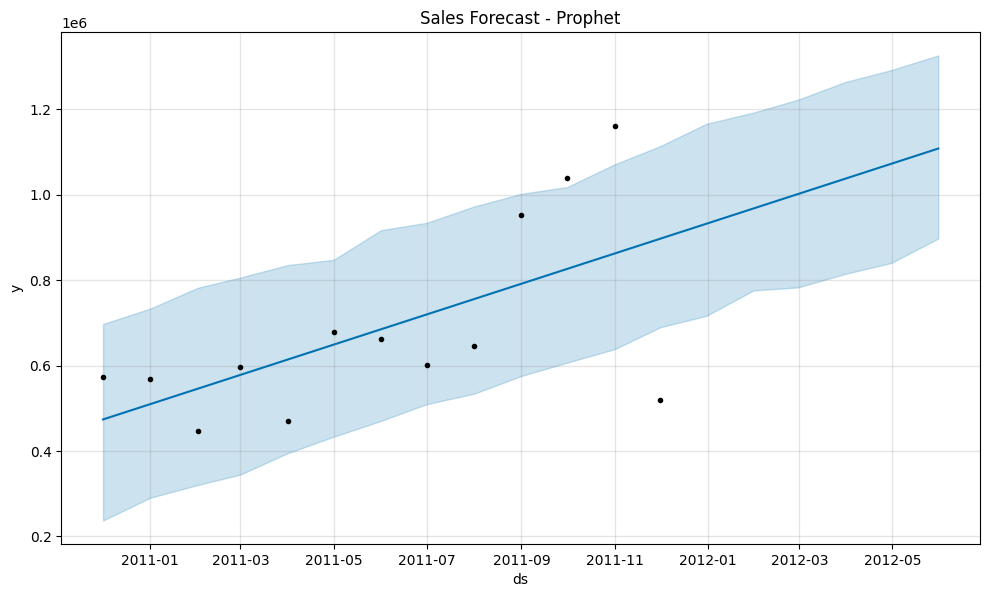

,ds,yhat,Action
13,2011-12-31,9.319729e+05,Increase 🔼
14,2012-01-31,9.679451e+05,Increase 🔼
15,2012-02-29,1.001596e+06,Increase 🔼
16,2012-03-31,1.037569e+06,Increase 🔼
17,2012-04-30,1.072380e+06,Increase 🔼
18,2012-05-31,1.108352e+06,Increase 🔼


In [22]:
monthly_prophet = monthly.copy()
monthly_prophet.columns = ['ds', 'y']

model = Prophet()
model.fit(monthly_prophet)

future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

model.plot(forecast)
plt.title("Sales Forecast - Prophet")
plt.show()

# Forecast + Recommendation
mean_revenue = monthly['Revenue'].mean()
recent_forecast = forecast[['ds', 'yhat']].tail(6)
recent_forecast['Action'] = recent_forecast['yhat'].apply(
    lambda x: 'Increase 🔼' if x > mean_revenue + 0.1 * mean_revenue
    else 'Reduce 🔽' if x < mean_revenue - 0.1 * mean_revenue
    else 'Maintain 🔄'
)
recent_forecast


In [23]:
volatility = df.groupby(['Description', 'YearMonth'])['TotalPrice'].sum().reset_index()
volatility_score = volatility.groupby('Description')['TotalPrice'].std().reset_index().sort_values(by='TotalPrice', ascending=False)
volatility_score.columns = ['Product', 'Volatility']
print(volatility_score.head(5))


                                 Product    Volatility
1992      MEDIUM CERAMIC TOP STORAGE JAR  25552.530130
2656                  RABBIT NIGHT LIGHT   7817.148882
2130                              Manual   5912.777254
2313     PAPER CHAIN KIT 50'S CHRISTMAS    4859.994429
3698  WHITE HANGING HEART T-LIGHT HOLDER   3873.424151


In [26]:
pysqldf = lambda q: sqldf(q, globals())

# a) Customer Lifetime Value
q1 = """
SELECT CustomerID, ROUND(SUM(TotalPrice), 2) AS CLV
FROM df
GROUP BY CustomerID
HAVING CLV > 1000
ORDER BY CLV DESC
LIMIT 10;
"""
print("Top 10 Customers by Lifetime Value:")
print(pysqldf(q1))

# b) Product Performance by Country
q2 = """
SELECT Country, Description, SUM(TotalPrice) AS Revenue
FROM df
GROUP BY Country, Description
ORDER BY Revenue DESC
LIMIT 10;
"""
print("\nTop 10 Products by Country Revenue:")
print(pysqldf(q2))

# c) Weekly High Sales Summary
q3 = """
SELECT Weekday, COUNT(*) AS HighSalesCount
FROM df
WHERE HighSale = 1
GROUP BY Weekday
ORDER BY HighSalesCount DESC;
"""
print("\nHigh-Sale Transactions by Weekday:")
print(pysqldf(q3))


Top 10 Customers by Lifetime Value:
   CustomerID        CLV
0     14646.0  280206.02
1     18102.0  259657.30
2     17450.0  194550.79
3     16446.0  168472.50
4     14911.0  143825.06
5     12415.0  124914.53
6     14156.0  117379.63
7     17511.0   91062.38
8     16029.0   81024.84
9     12346.0   77183.60

Top 10 Products by Country Revenue:
          Country                         Description    Revenue
0  United Kingdom         PAPER CRAFT , LITTLE BIRDIE  168469.60
1  United Kingdom            REGENCY CAKESTAND 3 TIER  110990.20
2  United Kingdom  WHITE HANGING HEART T-LIGHT HOLDER   94858.60
3  United Kingdom      MEDIUM CERAMIC TOP STORAGE JAR   80291.44
4  United Kingdom             JUMBO BAG RED RETROSPOT   77371.57
5  United Kingdom                       PARTY BUNTING   63109.38
6  United Kingdom       ASSORTED COLOUR BIRD ORNAMENT   52395.99
7  United Kingdom                       CHILLI LIGHTS   45505.31
8  United Kingdom     PAPER CHAIN KIT 50'S CHRISTMAS    40451.08
9 

In [25]:
# After adding the HighSale column
threshold = df['TotalPrice'].quantile(0.75)
df['HighSale'] = df['TotalPrice'].apply(lambda x: 1 if x > threshold else 0)

# Define pysqldf with updated context
from pandasql import sqldf
env = {'df': df}  # 👈 Very important for custom variables
pysqldf = lambda q: sqldf(q, env)


In [27]:
recent = df[df['InvoiceDate'] >= '2011-10-01']
unsold = set(df['StockCode']) - set(recent['StockCode'])
print("Deadstock Products (not sold in Oct-Nov):", len(unsold))


Deadstock Products (not sold in Oct-Nov): 738


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Create HighSale classification target
threshold = df['TotalPrice'].quantile(0.75)
df['HighSale'] = df['TotalPrice'].apply(lambda x: 1 if x > threshold else 0)

# Step 2: Features and Scaling
features = df[['Quantity', 'UnitPrice', 'Month', 'Weekday', 'Hour']]
target = df['HighSale']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_probs = clf.predict_proba(X_test_scaled)[:, 1]


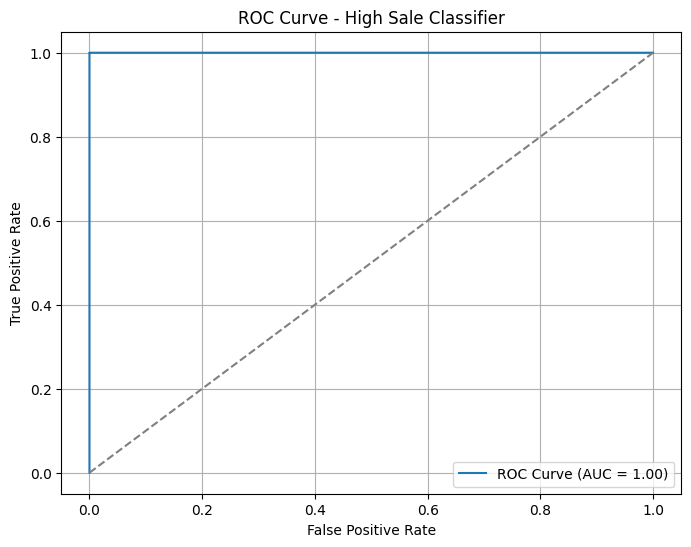

Optimal Cutoff Point: 0.40


In [29]:
# Step 4: ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - High Sale Classifier")
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Optimal threshold using Youden’s J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Cutoff Point: {optimal_threshold:.2f}")


In [30]:
# Step 6: Final prediction using optimal threshold
y_pred_opt = (y_probs >= optimal_threshold).astype(int)

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_opt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt, target_names=["Low Sale", "High Sale"]))


Confusion Matrix:
[[60966    11]
 [    3 18597]]

Classification Report:
              precision    recall  f1-score   support

    Low Sale       1.00      1.00      1.00     60977
   High Sale       1.00      1.00      1.00     18600

    accuracy                           1.00     79577
   macro avg       1.00      1.00      1.00     79577
weighted avg       1.00      1.00      1.00     79577

